# 1. Introduction
This part of the project consists of building an stress detection system. There are 5 stress levels: 1, 2, 3, 4, 5 in increasing stress. The data is collected from the participants of the AffecTech project. 

* 1: _reserved_
* 2: yoga, mindfulness
* 3: lecture, free walking in Bebek, dancing
* 4: meeting for presentation
* 5: presentation

# 2. Data
The given data includes predicted activities (during the Activity Recognition section of the project), electrodermal activity (EDA), and interbeat interval (IBI) from Empatica devices.

# 3. Data preprocessing
## 3.1. Get EDA data

In [1]:
import csv
import numpy as np
import pandas as pd

In [2]:
import os
import glob

eda_files = glob.glob( 'EDA.csv' )

In [3]:
import re

def append_eda_file_to_dataframe(file_name):
    file_location = cwd + "/" + file_name
    with open(file_location, "r") as f:
        reader = csv.reader(f, delimiter=",")
        start_time = 0
        values = []
        times = []
        prev_time = 0
        for i, line in enumerate(reader):
            if i is 0:
                start_time = float(line[0])
                prev_time = start_time
            elif i is 1:
                frequency_eda = float(line[0])
            else:
                if start_time + 10 <= prev_time:
                    times.append(prev_time)
                    values.append(float(line[0]))
                prev_time += 1/frequency_eda
    return pd.DataFrame(
        {'time': times,
         'value_eda': values,
         'device': re.findall("_(.*?)\/", file_name)[0]
        })

In [4]:
cwd = os.getcwd()  # Get the current working directory (cwd)
    
eda_list = [] 
for file in eda_files:
    eda_list.append(append_eda_file_to_dataframe(file))

### 3.1.1. Glimpse of EDA peaks

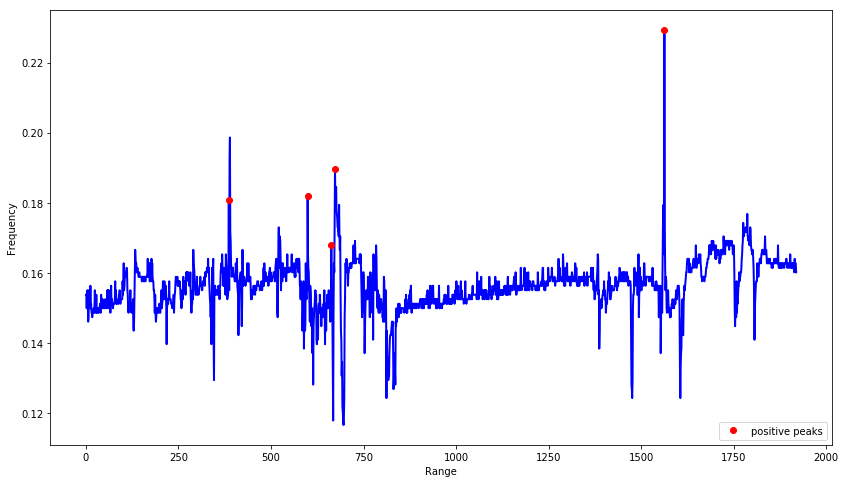

In [6]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

example_values = eda_list[4].iloc[1920:(1920 + (8 * 60 * int(4)))]['value_eda'].as_matrix()
peaks_positive, _ = find_peaks(example_values, threshold =0.01, distance=5, height=0)

plt.figure(figsize = (14, 8))
plt.plot(np.arange(4 * 60 * 8), example_values, 'b-', linewidth = 2)

plt.plot(np.arange(4 * 60 * 8)[peaks_positive], example_values[peaks_positive], 'ro', label = 'positive peaks')

plt.xlabel('Range')
plt.ylabel('Frequency')
plt.legend(loc = 4)
plt.savefig('eda_peaks.png', dpi=100)
plt.show()

## 3.2. Get IBI data

In [7]:
ibi_files = glob.glob( '*/*/*/IBI.csv' )

In [8]:
def append_ibi_file_to_dataframe(file_name):
    file_location = cwd + "/" + file_name
    with open(file_location, "r") as f:
        reader = csv.reader(f, delimiter=",")
        start_time = 0
        times = []
        current_time = 0
        for i, line in enumerate(reader):
            if i is 0:
                start_time = float(line[0])
                current_time = start_time
            else:
                if start_time + 10 <= current_time:
                    times.append(current_time)
                current_time += float(line[0])
    return pd.DataFrame(
        {'time': times,
         'device': re.findall("_(.*?)\/", file_name)[0]
        })

In [9]:
ibi_list = []
for file in ibi_files:
    ibi_list.append(append_ibi_file_to_dataframe(file))

## 3.3. Get activity data

Found, processed, and written to detected_activity.csv in Activity Recognition. Thus, activity data is exempted from domain conversion in Section 3.4.

In [10]:
acc_df = pd.read_csv("detected_activity.csv", sep='\t', encoding='utf-8')

## 3.4. Convert data from time domain to frequency domain

In [11]:
import statistics

def eda_time_domain_to_frequency_domain(df, frequency):
    brand_new_df = pd.DataFrame()
    num_rows = df.shape[0]
    i = 0
    while i < (num_rows - 8 * 60 * frequency):
        values = df.iloc[i:(i + (8 * 60 * int(frequency)))]['value_eda'].as_matrix()
        mean = sum(values)/len(values)
        std = statistics.stdev(values)
        peaks_positive, _ = find_peaks(values, threshold =0.01, distance=5, height=0)
        pps = len(peaks_positive)
        df_new = pd.DataFrame(
                    {
                     'start_time': df['time'][i],
                     'end_time': df['time'][i + (8 * 60 * int(frequency)) - 1],
                     'mean': [mean],
                     'std': [std],
                     'pps': [pps]
                    })
        i = i + (8 * 60 * int(frequency))
        brand_new_df = pd.concat([brand_new_df, df_new], ignore_index=True)
    return brand_new_df

In [12]:
def ibi_time_domain_to_frequency_domain(df):
    brand_new_df = pd.DataFrame()
    num_rows = df.shape[0]
    if num_rows < 1:
        return brand_new_df
    start_time = df.time[0]
    while start_time < df.time[num_rows -1]:
        values = df.ix[(df['time'] > start_time) & (df['time'] < (start_time + 480))].time.as_matrix()
        while (len(values) < 2):
            start_time = start_time + 480
            if start_time < df.time[num_rows -1]:
                return brand_new_df
            values = df.ix[(df['time'] > start_time) & (df['time'] < (start_time + 480))].time.as_matrix()
        rr_values = np.diff(values)
        if len(values) is 2:
            std = 0
        elif len(values) > 2:
            std = statistics.stdev(rr_values)
        mean = sum(rr_values)/len(rr_values)
        df_new = pd.DataFrame(
                    {
                     'start_time': values[0],
                     'end_time': values[len(values) - 1],
                     'mean': [mean],
                     'std': [std],
                     'device': df.device[0]
                    })
        brand_new_df = pd.concat([brand_new_df, df_new], ignore_index=True)
        start_time = start_time + 480
    return brand_new_df

In [13]:
eda_df = []
for frame in eda_list:
    eda_df.append(eda_time_domain_to_frequency_domain(frame, 4))
eda_df = pd.concat(eda_df, ignore_index=True)

ibi_df = []
for frame in ibi_list:
    ibi_df.append(ibi_time_domain_to_frequency_domain(frame))
ibi_df = pd.concat(ibi_df, ignore_index=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


## 3.4. Merge EDA data, IBI data and activity data

In [14]:
# Merge EDA and activity data
import sqlite3

conn = sqlite3.connect(':memory:')
acc_df.to_sql('acc_df', conn, index=False)
eda_df.to_sql('eda_df', conn, index=False)

qry = '''
    select
        acc_df.predicted_y predicted_y,
        eda_df.mean eda_mean,
        eda_df.std eda_std,
        eda_df.pps eda_pps,
        eda_df.start_time start_time,
        eda_df.end_time end_time,
        acc_df.stress
    from
        acc_df
    join
        eda_df
    on
        (eda_df.start_time >= acc_df.UTC_start) and (acc_df.UTC_end >= eda_df.end_time)
    '''

eda_activity_df = pd.read_sql_query(qry, conn)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1534: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  chunksize=chunksize, dtype=dtype)


In [15]:
# Merge resulting dataframe in the previous cell with IBI data

conn = sqlite3.connect(':memory:')
eda_activity_df.to_sql('eda_activity_df', conn, index=False)
ibi_df.to_sql('ibi_df', conn, index=False)

qry = '''
    select
        eda_activity_df.predicted_y predicted_y,
        eda_activity_df.eda_mean,
        eda_activity_df.eda_std,
        eda_activity_df.eda_pps,
        eda_activity_df.stress,
        ibi_df.mean ibi_mean
    from
        eda_activity_df
    join
        ibi_df
    on
        (ibi_df.start_time >= eda_activity_df.start_time) and (eda_activity_df.end_time >= ibi_df.end_time)
    '''

eda_activity_ibi_df = pd.read_sql_query(qry, conn)

In [16]:
eda_activity_ibi_df['int_y'] = eda_activity_ibi_df['predicted_y'].map({'low': 0, 'medium': 1, 'high': 2})
eda_activity_ibi_df.drop(['predicted_y'], axis=1, inplace=True)

# 4. Machine Learning

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import SelectFromModel

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 4.1. Excluding activity data

In [28]:
# Features and target
X = eda_activity_ibi_df[['eda_mean', 'eda_std', 'eda_pps', 'ibi_mean']]
y = eda_activity_ibi_df['stress']

### 4.1.1. Logistic Regression
#### 4.1.1.1. Feature Selection

In [29]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=10, multi_class='ovr', class_weight='balanced')
sfm = SelectFromModel(clf)
sfm.fit(X, y)
selected_features = np.array(list(X.columns))
result = selected_features[sfm.get_support()]
result.tolist()

['eda_std']

#### 4.1.1.2. Model Application

In [30]:
X_lr = X[['eda_std']]
y_lr = y

X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=0.2)

clf = LogisticRegressionCV(cv=10, multi_class='ovr', class_weight='balanced').fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

0.17510729613733905

### 4.1.2. Naive Bayes
#### 4.1.2.1. Model Application

In [31]:
from sklearn.naive_bayes import GaussianNB

X_nb = X
y_nb = y

X_train, X_test, y_train, y_test = train_test_split(X_nb, y_nb, test_size=0.2)

gnb = GaussianNB().fit(X_train, y_train)
gnb.predict(X_test)
gnb.score(X_test, y_test)

0.6935622317596567

### 4.1.3. Decision Tree
#### 4.1.3.1. Feature Selection

In [32]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(class_weight='balanced')
sfm = SelectFromModel(clf)
sfm.fit(X, y)
selected_features = np.array(list(X.columns))
result = selected_features[sfm.get_support()]
result.tolist()

['ibi_mean']

#### 4.1.3.2. Model Application

In [33]:
X_dt = X[['ibi_mean']]
y_dt = y

X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt, test_size=0.2)

clf = tree.DecisionTreeClassifier(class_weight='balanced')
clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

0.9957081545064378

### 4.1.4. Multi-layer Perceptron
#### 4.1.4.1. Model Application

In [34]:
from sklearn.neural_network import MLPClassifier

X_mlp = X
y_mlp = y

X_train, X_test, y_train, y_test = train_test_split(X_mlp, y_mlp, test_size=0.2)

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

0.6892703862660944

## 4.2. Including activity data

In [35]:
# Features and target
X = eda_activity_ibi_df[['eda_mean', 'eda_std', 'eda_pps', 'int_y', 'ibi_mean']]
y = eda_activity_ibi_df['stress']

### 4.2.1. Logistic Regression
#### 4.2.1.1. Feature Selection

In [36]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=10, multi_class='ovr', class_weight='balanced')
sfm = SelectFromModel(clf)
sfm.fit(X, y)
selected_features = np.array(list(X.columns))
result = selected_features[sfm.get_support()]
result.tolist()

['int_y']

#### 4.2.1.2. Model Application

In [37]:
X_lr = X[['int_y']]
y_lr = y

X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=0.2)

clf = LogisticRegressionCV(cv=10, multi_class='ovr', class_weight='balanced').fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

0.3098712446351931

### 4.2.2. Naive Bayes
#### 4.2.2.1. Model Application

In [38]:
from sklearn.naive_bayes import GaussianNB

X_nb = X
y_nb = y

X_train, X_test, y_train, y_test = train_test_split(X_nb, y_nb, test_size=0.2)

gnb = GaussianNB().fit(X_train, y_train)
gnb.predict(X_test)
gnb.score(X_test, y_test)

0.5399141630901287

### 4.2.3. Decision Tree
#### 4.2.3.1. Feature Selection

In [39]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(class_weight='balanced')
sfm = SelectFromModel(clf)
sfm.fit(X, y)
selected_features = np.array(list(X.columns))
result = selected_features[sfm.get_support()]
result.tolist()

['int_y', 'ibi_mean']

#### 4.2.3.2. Model Application

In [40]:
X_dt = X[['int_y', 'ibi_mean']]
y_dt = y

X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt, test_size=0.2)

clf = tree.DecisionTreeClassifier(class_weight='balanced')
clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

0.9948497854077253

### 4.2.4. Multi-layer Perceptron
#### 4.2.4.1. Model Application

In [41]:
X_mlp = X
y_mlp = y

X_train, X_test, y_train, y_test = train_test_split(X_mlp, y_mlp, test_size=0.2)

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

0.6686695278969957

# 5. Conclusion

Accuracy of each model in Section 4:

| ML models              | Excluding activity data | Including activity data |
|------------------------|-------------------------|-------------------------|
| Logistic Regression    | 0.175                   | 0.309                   |
| Naive Bayes            | 0.693                   | 0.539                   |
| Decision Tree          | 0.995                   | 0.994                   |
| Multi-layer Perceptron | 0.689                   | 0.668                   |